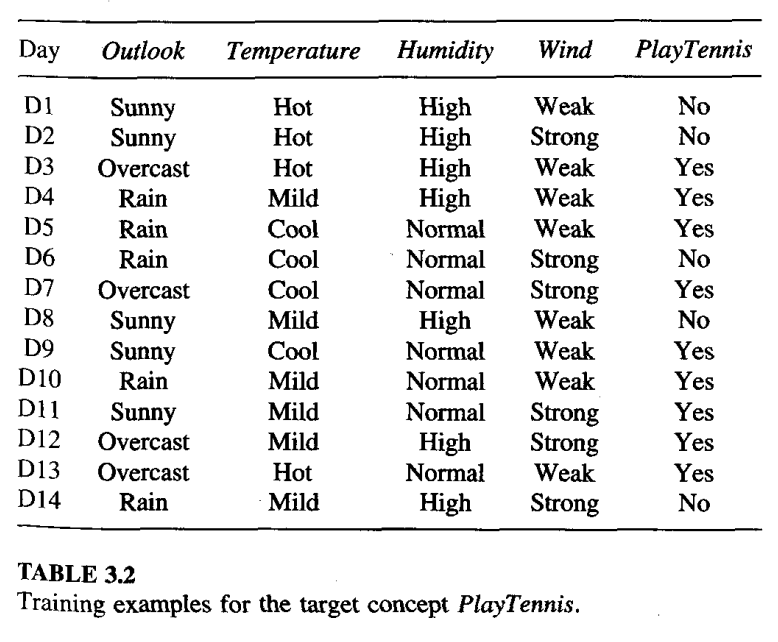

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Considering only binary classes

features_names = ['Outlook', 'Humidity', 'Wind']
target_name = 'PlayTennis'
data = np.asarray([['Sunny', 'High', 'Weak', 'No'],
 ['Sunny', 'High', 'Strong', 'No'],
 ['Rain', 'High', 'Weak', 'Yes'],
 ['Rain', 'Normal', 'Weak', 'Yes'],
 ['Rain', 'Normal', 'Strong', 'No'],
 ['Sunny', 'High', 'Weak', 'No'],
 ['Sunny', 'Normal', 'Weak', 'Yes'],
 ['Rain', 'Normal', 'Weak', 'Yes'],
 ['Sunny', 'Normal', 'Strong', 'Yes'],
 ['Rain', 'High', 'Strong', 'No']])

X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.3, random_state=4)

In [ ]:
class Attribute:
    def __init__(self, id, label, vals):
        self.id = id
        self.label = label
        self.vals = sorted(set(vals))
    def __repr__(self):
        return f'Attribute(id={self.id}, label={self.label}, vals={self.vals})'

In [ ]:
pos, neg = 'Yes', 'No'
attributes = []
for i, name in enumerate(features_names):
    attributes.append(Attribute(i, name, X_train.T[i]))

# Decision Trees

### Custom Implementation

In [ ]:
from math import log2
from json import dumps

class DecisionTreeID3:

    class DecisionNode:
        def __init__(self):
            self.label = None
            self.attr = None
            self.branches = {}
            self.gain = 0
        def __repr__(self):
            return f'DN{id(self)}'

    def __init__(self, examples, target_attr, attributes, pos=1, neg=0):
        self.root = self.ID3(examples, target_attr, attributes.copy(), pos, neg)
        self.attributes = attributes
    
    def ID3(self, examples, target_attr, attributes, pos=1, neg=0):
        root = self.DecisionNode()
        p_pos = 0
        p_neg = 0
        for example in examples:
            v = example[target_attr]
            if v==pos: p_pos+=1
            elif v==neg: p_neg+=1
        if p_pos==len(examples):
            root.label = pos
            return root
        if p_neg==len(examples):
            root.label = neg
            return root
        if len(attributes)==0:
            root.label = self.mode(examples, target_attr)
            return root
        
        attributes.sort(key = lambda A: self.gain(examples, A, target_attr, pos, neg), reverse=True)
        A = attributes[0]
        root.attr = A
        root.gain = self.gain(examples, A, target_attr, pos, neg)
        for vi in A.vals:
            examples_vi = self.get_subset(examples, vi, A.id)
            if len(examples_vi)==0:
                leaf = self.DecisionNode()
                leaf.label = self.mode(examples, target_attr)
                root.branches[vi] = leaf
            else:
                atts = attributes.copy()
                atts.pop(0)
                subtree = self.ID3(examples_vi, target_attr, atts, pos, neg)
                root.branches[vi] = subtree
        return root

    def entropy(self, S, target_attr, pos=1, neg=0):
        p_pos = 0
        p_neg = 0
        for Si in S:
            v = Si[target_attr]
            if v==pos: p_pos+=1
            elif v==neg: p_neg+=1
        if p_pos==0 or p_neg==0: return 0
        t = p_pos+p_neg
        p_pos/=t
        p_neg/=t
        return - p_pos*log2(p_pos) - p_neg*log2(p_neg)
    
    def gain(self, S, A, target_attr, pos=1, neg=0):
        s = 0
        for v in A.vals:
            Sv = self.get_subset(S, v, A.id)
            s += self.entropy(Sv, target_attr, pos, neg)*len(Sv)/len(S)
        return self.entropy(S, target_attr, pos, neg) - s

    def mode(self, X, attr):
        d = {}
        for Xi in X:
            v = Xi[attr]
            d[v] = d.get(v, 0) + 1
        return max(d, key=d.get)

    def get_subset(self, examples, vi, attr):
        examples_vi = []
        for example in examples:
            if example[attr]==vi:
                examples_vi.append(example)
        return examples_vi
    
    def generate_json_tree(self):
        def p(n):
            d = {'gain': "%.2f" % n.gain}
            if n.label!=None: d['label'] = n.label
            if n.attr!=None: d['attribute'] = n.attr.label
            b = {}
            for v, c in n.branches.items():
                b[v] = p(c, )
            if len(b)!=0: d['branches'] = b
            return d
        return dumps(p(self.root), indent=3)
    
    def predict(self, X):
        def g(Xi, node):
            if node.label!=None: return node.label
            return g(Xi, node.branches[Xi[node.attr.id]])
        y = []
        for Xi in X:
            y.append(g(Xi, self.root))
        return np.asarray(y)

In [ ]:
examples = np.hstack((X_train, y_train.reshape(-1, 1)))
decision_tree = DecisionTreeID3(examples, len(features_names), attributes.copy(), pos, neg)
y_prediction = decision_tree.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_prediction))
print('\nClassification Report:\n\n', classification_report(y_test, y_prediction, target_names=['Yes', 'No']))

Accuracy: 0.6666666666666666

Classification Report:

               precision    recall  f1-score   support

         Yes       0.00      0.00      0.00         1
          No       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(decision_tree.generate_json_tree())

{
   "gain": "0.47",
   "attribute": "Humidity",
   "branches": {
      "High": {
         "gain": "0.32",
         "attribute": "Outlook",
         "branches": {
            "Rain": {
               "gain": "1.00",
               "attribute": "Wind",
               "branches": {
                  "Strong": {
                     "gain": "0.00",
                     "label": "No"
                  },
                  "Weak": {
                     "gain": "0.00",
                     "label": "Yes"
                  }
               }
            },
            "Sunny": {
               "gain": "0.00",
               "label": "No"
            }
         }
      },
      "Normal": {
         "gain": "0.00",
         "label": "Yes"
      }
   }
}


Visit [Online JSON to Tree Diagram Converter](https://vanya.jp.net/vtree/) &amp; use the above JSON code to generate Decision Tree diagram.

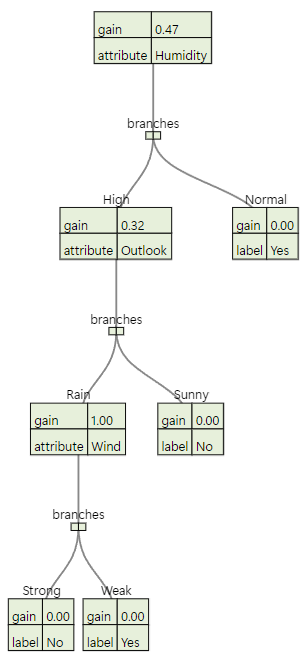

### SKlearn
Sklearn uses an optimized version of CART algorithm.
More information can be found here: 
https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart

In [ ]:
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

def attrs_to_dict(attrs):
    d = {}
    for attr in attrs:
        di = {}
        for i, val in enumerate(attr.vals):
            di[val] = i
        d[attr.id] = di
    return d

def numerize_data(X, attrs):
    X_ = []
    d = attrs_to_dict(attrs)
    for Xi in X:
        X_i = []
        for i, xi in enumerate(Xi):
            X_i.append(d[i][xi])
        X_.append(X_i)
    return np.asarray(X_)

Accuracy: 0.6666666666666666

Classification Report:

               precision    recall  f1-score   support

          No       0.00      0.00      0.00         1
         Yes       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


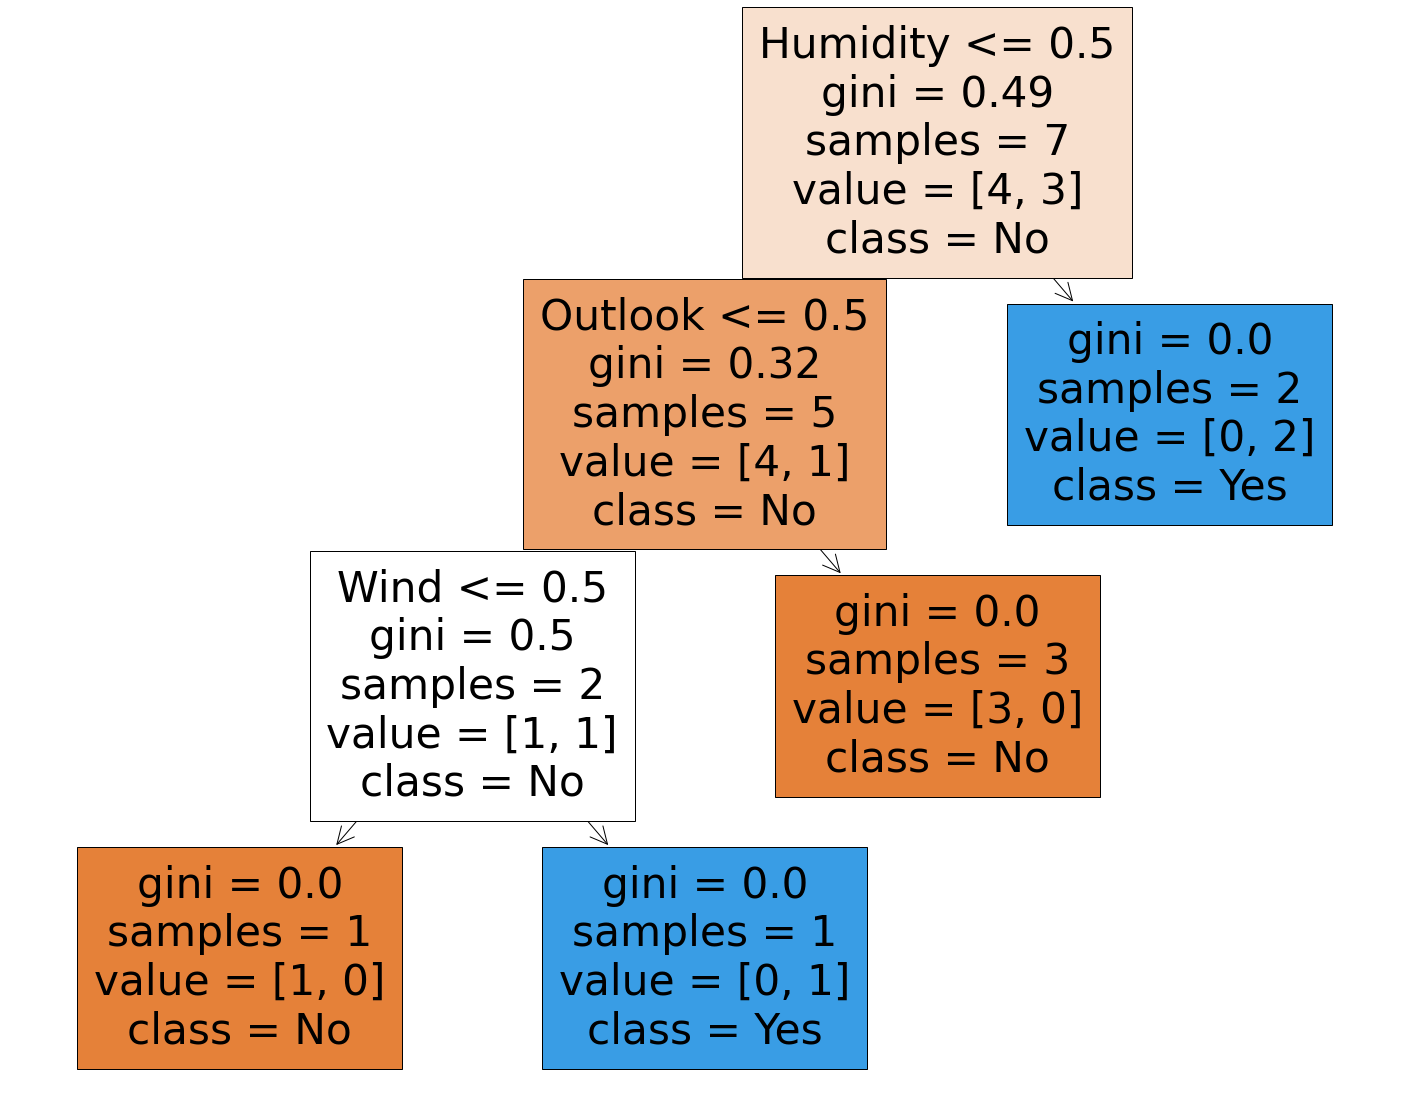

In [ ]:
clf = DecisionTreeClassifier()

X_train_ = numerize_data(X_train, attributes)
model = clf.fit(X_train_, y_train)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, feature_names=features_names, class_names=['No', 'Yes'], filled=True)

X_test_ = numerize_data(X_test, attributes)
y_pred = model.predict(X_test_)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n\n', classification_report(y_test, y_pred))

## With more features & classes

In [ ]:
original_data = np.asarray([['D1', 'Sunny', 'Hot', 'High', 'Weak', 'No'],
['D2', 'Sunny', 'Hot', 'High', 'Strong', 'No'],
['D3', 'Overcast', 'Hot', 'High', 'Weak', 'Yes'],
['D4', 'Rain', 'Mild', 'High', 'Weak', 'Yes'],
['D5', 'Rain', 'Cool', 'Normal', 'Weak', 'Yes'],
['D6', 'Rain', 'Cool', 'Normal', 'Strong', 'No'],
['D7', 'Overcast', 'Cool', 'Normal', 'Strong', 'Yes'],
['D8', 'Sunny', 'Mild', 'High', 'Weak', 'No'],
['D9', 'Sunny', 'Cool', 'Normal', 'Weak', 'Yes'],
['D10', 'Rain', 'Mild', 'Normal', 'Weak', 'Yes'],
['D11', 'Sunny', 'Mild', 'Normal', 'Strong', 'Yes'],
['D12', 'Overcast', 'Mild', 'High', 'Strong', 'Yes'],
['D13', 'Overcast', 'Hot', 'Normal', 'Weak', 'Yes'],
['D14', 'Rain', 'Mild', 'High', 'Strong', 'No']])

features_names_od = ['Outlook', 'Temperature', 'Humidity', 'Wind']
target_name_od = 'PlayTennis'

X_od, y_od = original_data[:, 1:-1], original_data[:, -1]
print(X_od, y_od)

pos, neg = 'Yes', 'No'
examples_od = np.hstack((X_od, y_od.reshape(-1, 1)))
attributes_od = []
for i, name in enumerate(features_names_od):
    attributes_od.append(Attribute(i, name, X_od.T[i]))
print(attributes_od)

[['Sunny' 'Hot' 'High' 'Weak']
 ['Sunny' 'Hot' 'High' 'Strong']
 ['Overcast' 'Hot' 'High' 'Weak']
 ['Rain' 'Mild' 'High' 'Weak']
 ['Rain' 'Cool' 'Normal' 'Weak']
 ['Rain' 'Cool' 'Normal' 'Strong']
 ['Overcast' 'Cool' 'Normal' 'Strong']
 ['Sunny' 'Mild' 'High' 'Weak']
 ['Sunny' 'Cool' 'Normal' 'Weak']
 ['Rain' 'Mild' 'Normal' 'Weak']
 ['Sunny' 'Mild' 'Normal' 'Strong']
 ['Overcast' 'Mild' 'High' 'Strong']
 ['Overcast' 'Hot' 'Normal' 'Weak']
 ['Rain' 'Mild' 'High' 'Strong']] ['No' 'No' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'No']
[Attribute(id=0, label=Outlook, vals=['Overcast', 'Rain', 'Sunny']), Attribute(id=1, label=Temperature, vals=['Cool', 'Hot', 'Mild']), Attribute(id=2, label=Humidity, vals=['High', 'Normal']), Attribute(id=3, label=Wind, vals=['Strong', 'Weak'])]


Unlike SKlearn implementation (which uses optimized CART algorithm to generate binary decision trees), **DecisionTreeID3** implementation can generate non-binary Decision Trees. However, the current implementation only supports binary target classes.<br><br>
In the below examples, the complete dataset is being used for both training and testing for demonstration purpose.

### Custom Implementation

In [ ]:
decision_tree_od = DecisionTreeID3(examples_od, len(features_names_od), attributes_od, pos, neg)
y_prediction = decision_tree_od.predict(X_od)

print('Accuracy:', accuracy_score(y_od, y_prediction))
print('\nClassification Report:\n\n', classification_report(y_od, y_prediction))
print('JSON Tree:\n', decision_tree_od.generate_json_tree())

Accuracy: 1.0

Classification Report:

               precision    recall  f1-score   support

          No       1.00      1.00      1.00         5
         Yes       1.00      1.00      1.00         9

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

JSON Tree:
 {
   "gain": "0.25",
   "attribute": "Outlook",
   "branches": {
      "Overcast": {
         "gain": "0.00",
         "label": "Yes"
      },
      "Rain": {
         "gain": "0.97",
         "attribute": "Wind",
         "branches": {
            "Strong": {
               "gain": "0.00",
               "label": "No"
            },
            "Weak": {
               "gain": "0.00",
               "label": "Yes"
            }
         }
      },
      "Sunny": {
         "gain": "0.97",
         "attribute": "Humidity",
         "branches": {
            "High": {
               "gain": "0.00",
               "

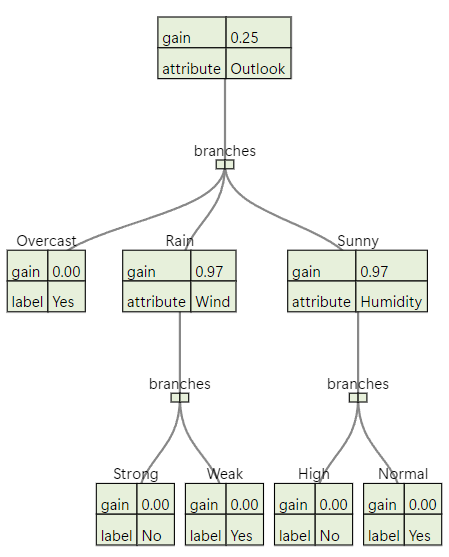

<br> Decision Tree - *Textbook Solution*

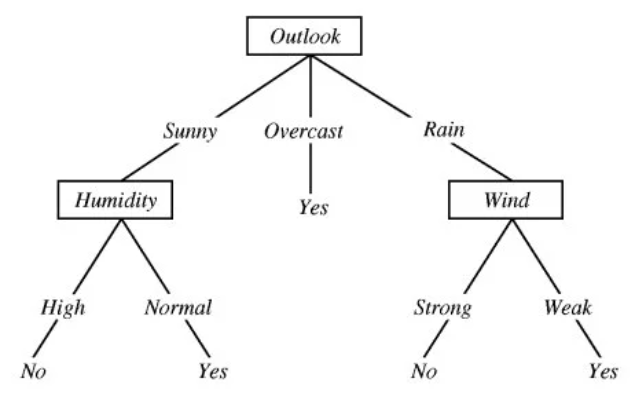

### SKlearn

Accuracy: 1.0

Classification Report:

               precision    recall  f1-score   support

          No       1.00      1.00      1.00         5
         Yes       1.00      1.00      1.00         9

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



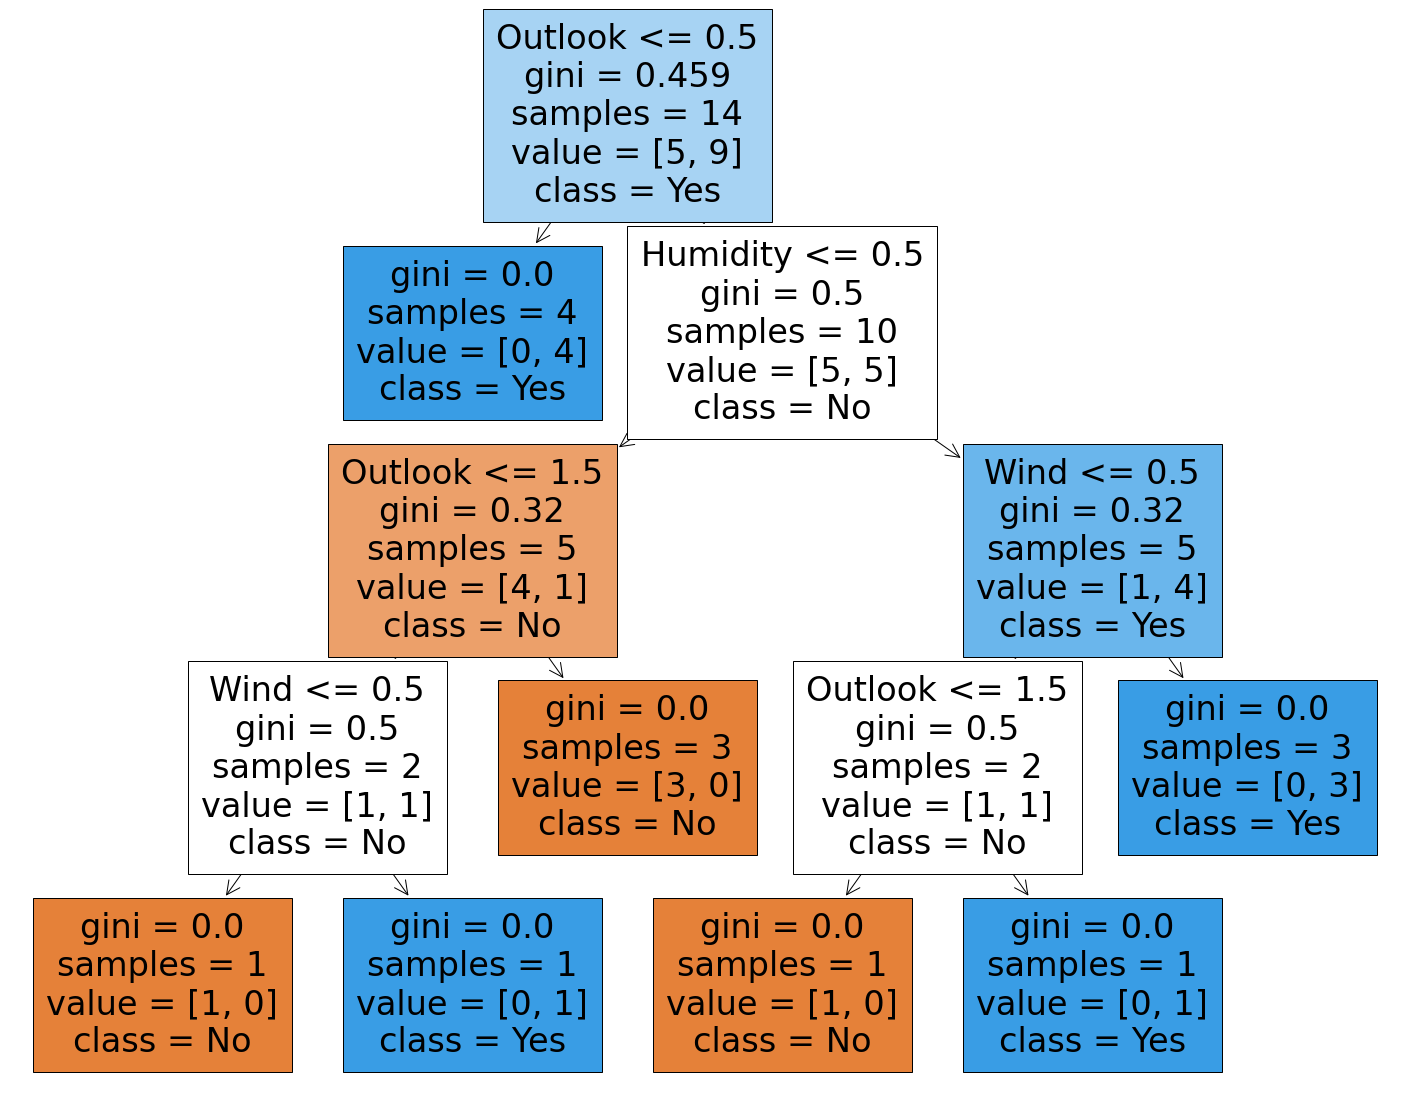

In [ ]:
clf = DecisionTreeClassifier()

X_ = numerize_data(X_od, attributes_od)
model = clf.fit(X_, y_od)

fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, feature_names=features_names_od, class_names=['No', 'Yes'], filled=True)

y_pred = model.predict(X_)

print('Accuracy:', accuracy_score(y_od, y_pred))
print('\nClassification Report:\n\n', classification_report(y_od, y_pred))

# Random Forests

### Custom Implementation

In [ ]:
from numpy.random import choice

class RandomForest:
    def __init__(self, X, y, attributes, N, k, pos=1, neg=0):
        data = np.hstack((X, y.reshape(-1, 1)))
        decision_trees = []
        for _ in range(N):
            sample, atts = self.random_subspace(data, attributes, k)
            decision_trees.append(DecisionTreeID3(sample, data.shape[1]-1, atts, pos, neg))
        self.decision_trees = decision_trees

    def random_subspace(self, X, attributes, k):
        # Bootstrapping
        random_indices = choice(X.shape[0], size=X.shape[0], replace=True)
        X = X[random_indices, :]
        # Select k Random Features
        random_features = choice(X.shape[1]-1, size=k, replace=False)
        atts = []
        for random_feature in random_features:
            atts.append(attributes[random_feature])
        return X, atts
    
    def predict(self, X):
        ys = []
        for decision_tree in self.decision_trees:
            ys.append(decision_tree.predict(X))
        y = []
        for i in range(len(X)):
            d = {}
            for j, ysj in enumerate(ys):
                v = ysj[i]
                d[v] = d.get(v, 0)+1
            yi = max(d, key=lambda x:d[x])
            y.append(yi)
        return y

In [ ]:
random_forest = RandomForest(X_train, y_train, attributes, 100, 2, pos, neg)

y_prediction = random_forest.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_prediction))
print('\nClassification Report:\n\n', classification_report(y_test, y_prediction, target_names=['Yes', 'No']))

Accuracy: 0.6666666666666666

Classification Report:

               precision    recall  f1-score   support

         Yes       0.00      0.00      0.00         1
          No       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SKlearn

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, max_features=2)

X_train_ = numerize_data(X_train, attributes)
clf.fit(X_train_, y_train)

X_test_ = numerize_data(X_test, attributes)
y_pred = clf.predict(X_test_)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n\n', classification_report(y_test, y_pred, target_names=['Yes', 'No']))

Accuracy: 0.6666666666666666

Classification Report:

               precision    recall  f1-score   support

         Yes       0.00      0.00      0.00         1
          No       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
